In [20]:
import pandas as pd
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
datapath = f"./data/AirPassengers.csv"
assert os.path.exists(datapath)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.figsize'] = 15,6
#plt.rcParams['figure.figsize'] = [12, 8]
#plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [21]:
TO_PREDICT = 12
deleted = None

In [219]:
df = pd.read_csv(datapath)
deleted = df.tail(TO_PREDICT)
df.drop(df.tail(TO_PREDICT).index, inplace = True)
df.Month = pd.to_datetime(df.Month)
df=df.set_index("Month")
df.sort_index(inplace=True)

In [23]:
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1959-08-01,559
1959-09-01,463
1959-10-01,407


<AxesSubplot:xlabel='Month', ylabel='#Passengers'>

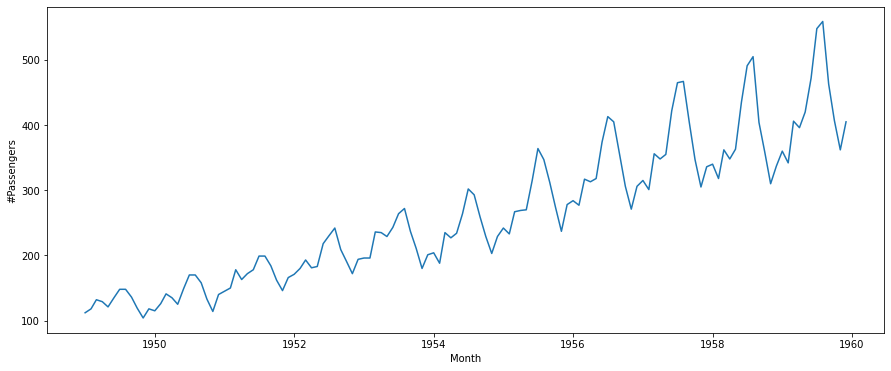

In [24]:
sns.lineplot(x="Month", y="#Passengers",data=df)

# Lets look for trends and seasonality

In [25]:
decomposition = seasonal_decompose(df)

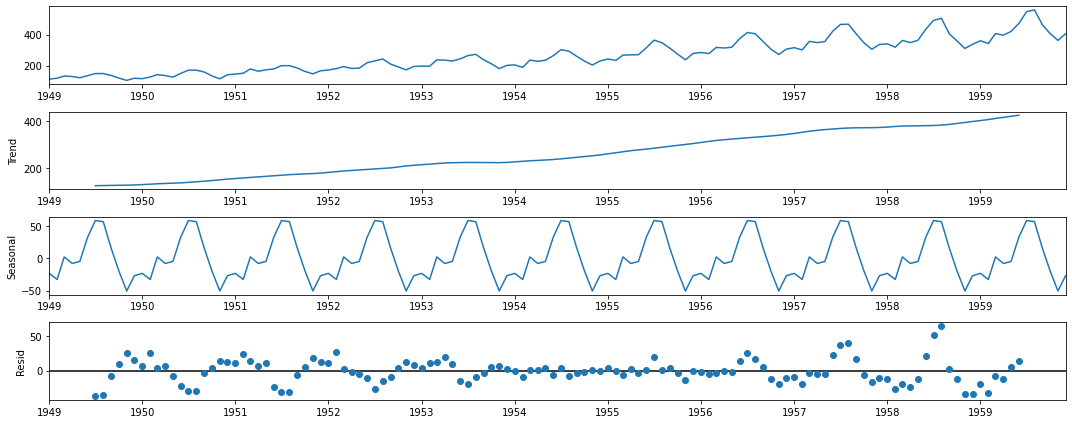

In [26]:
decomposition.plot()
plt.show()

We can clearly see that there is Trend and Seasonality, that means mean and variantions is varying over time. We don't want that... So the series is non-stationary. We have to eliminate trend and seasonality. To do that we could use differencing or decomposition. We have already done a decomposition so lets use that. We to sure that series is more or less stationary we will do Dickey-Fuller test. 
Where:

* Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [27]:
def Dickey_Fuller(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [28]:
Dickey_Fuller(df)

ADF Statistic: 0.888027
p-value: 0.992932
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


In [29]:
df_res = decomposition.resid.dropna()
Dickey_Fuller(df_res)

ADF Statistic: -4.447601
p-value: 0.000244
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582


We see a very lov p-value in test for decomposied time series. We can be sure that the series is close to stationary.

# ACF & PACF

In [55]:
def plot(series):
    print(len(series))
    plt.subplot(211)
    plot_acf(series, ax=plt.gca(),lags=len(series)-1)
    plt.subplot(212)
    plot_pacf(series, ax=plt.gca(),lags=(len(series)/2) -1)
    plt.show()

132


c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


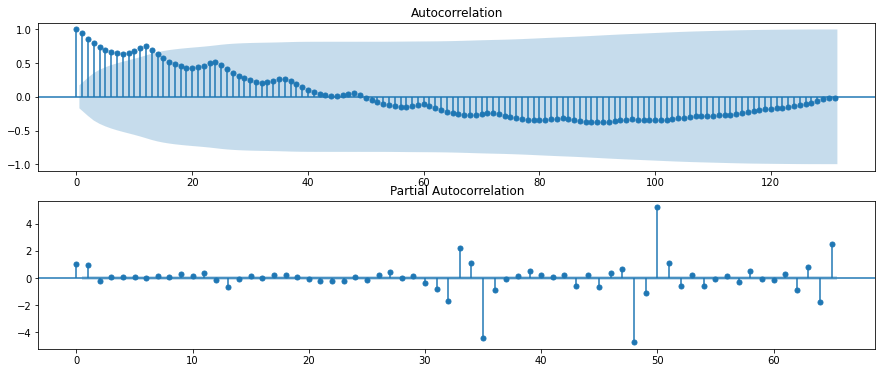

In [56]:
# just for example how it looks with non-stationary process
plot(df)

120


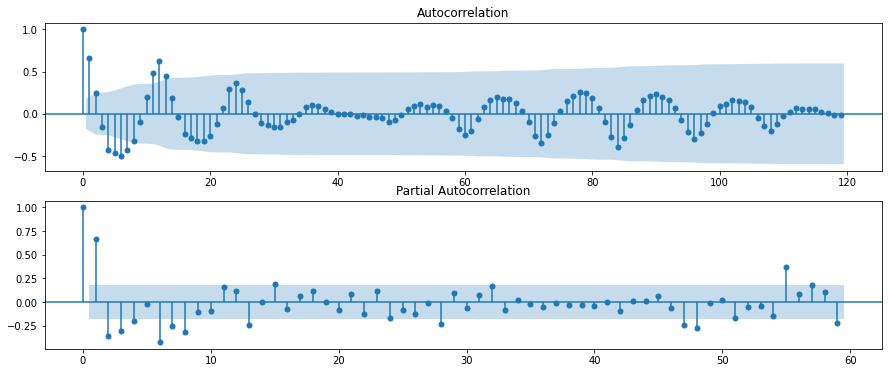

In [57]:
plot(df_res)

On ACF and PACF plots we can see that only few previous observations has inpact on new obseravations. 
We have to mention that ACF differs from PACF that PACF shows only direct inpact on new observation. It means that for example on AFC plot observation t-2 has inpact on observation t-1 so it has indirect inpact on observation t too. 

Knowing that we can cee that first 2 observations has direct inpact on new observations. Other are less significant and can noise our prediction.

But we can see that on ACF plot first 2 observations has direct and undirect inpact on new observation. Unfortunalty some of them are so unsignificant that can be taken as noise. 

# Model

In [115]:
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [203]:
p = 2 #from PACF
d = 1
q = 2 #from ACF


In [204]:
model = ARIMA(df_res, order = (p, d, 0))
results_AR = model.fit(disp = -1)

c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequen

Text(0.5, 1.0, 'RSS: 28363.3954')

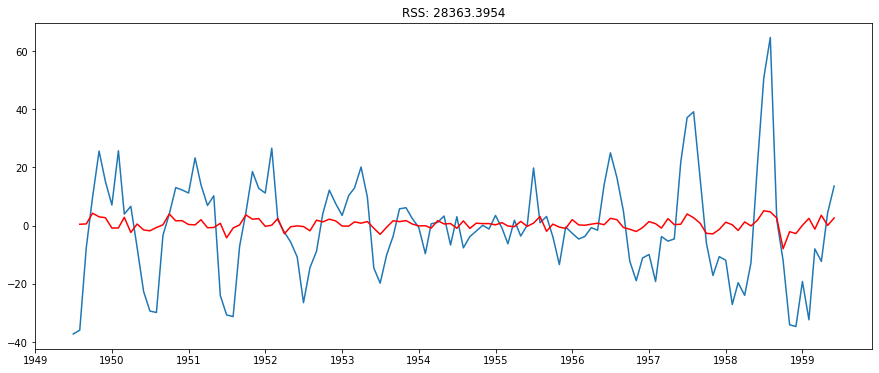

In [205]:
plt.plot(df_res)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - df_res).dropna()**2))

c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: 28363.3954')

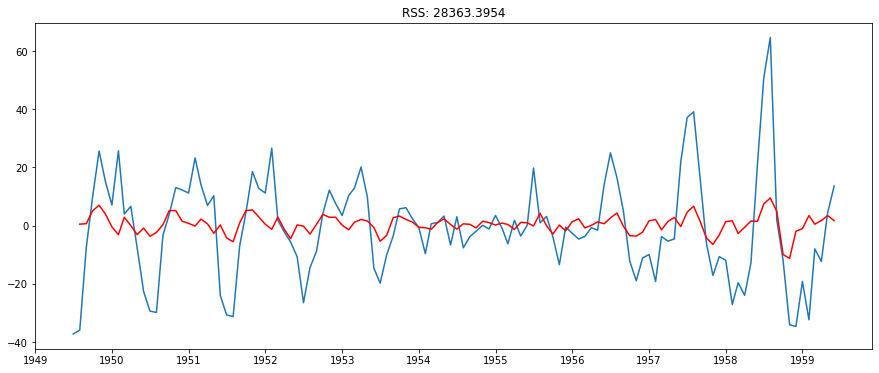

In [206]:
model = ARIMA(df_res, order= (0, d, q))  
results_MA = model.fit(disp = -1)  
plt.plot(df_res)
plt.plot(results_MA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum(((results_MA.fittedvalues - df_res).dropna())**2))

c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
c:\users\wilk\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this

Text(0.5, 1.0, 'RSS: 45436.8972')

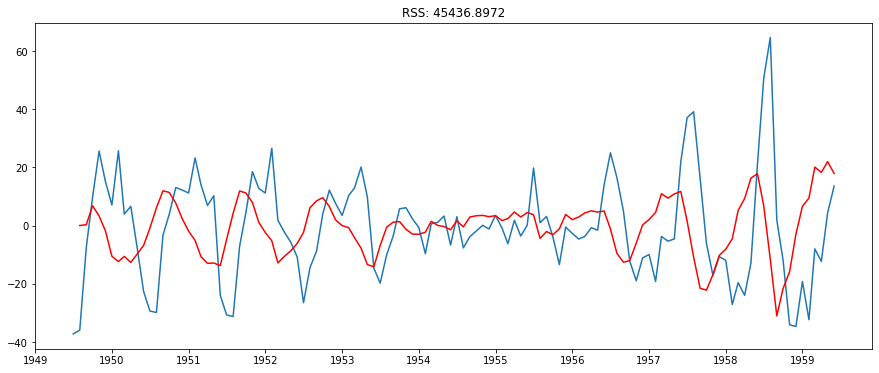

In [207]:

model = ARIMA(df_res, order= (p, d, q))  
results_MA = model.fit(disp = -1)  
plt.plot(df_res)
plt.plot(results_MA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum(((results_MA.fittedvalues - df_res).dropna())**2))

In [208]:
len(results_MA.fittedvalues)

119

In [209]:
(results_MA.fittedvalues - df_res).dropna()

Month
1949-08-01    35.951357
1949-09-01     7.882777
1949-10-01    -2.955497
1949-11-01   -22.302963
1949-12-01   -16.968136
                ...    
1959-02-01    41.815242
1959-03-01    28.099513
1959-04-01    30.586688
1959-05-01    17.574568
1959-06-01     4.313995
Length: 119, dtype: float64

In [210]:
decomposition.trend.dropna()+results_MA.fittedvalues

Month
1949-07-01           NaN
1949-08-01    127.249968
1949-09-01    128.256388
1949-10-01    135.372281
1949-11-01    132.283148
                 ...    
1959-02-01    416.601353
1959-03-01    431.960624
1959-04-01    434.610299
1959-05-01    442.473179
1959-06-01    443.383440
Length: 120, dtype: float64

In [211]:
def compose(season,trend,residuals):
    return (season+trend+residuals).dropna()

In [212]:
season = decomposition.seasonal.dropna()

In [213]:
trend = decomposition.trend.dropna()

In [214]:
composed = compose(season,trend,results_MA.fittedvalues)

Text(0.5, 1.0, 'RSS: 45436.8972 RMSE: 19.5403')

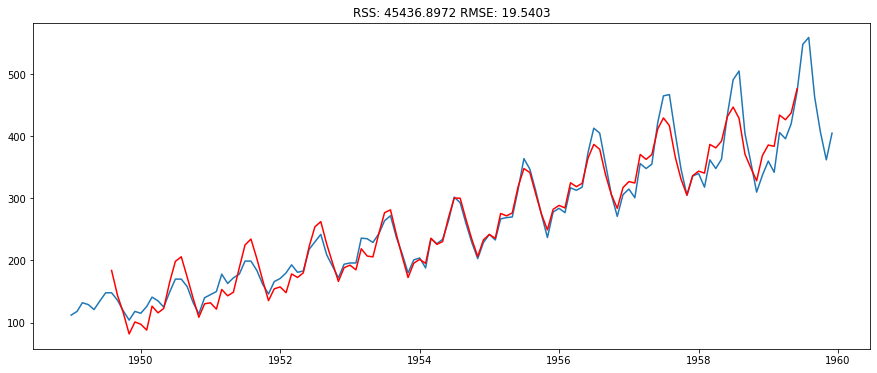

In [215]:
plt.plot(df)
plt.plot(composed, color= 'red')
RSS = sum((df["#Passengers"]-composed).dropna()**2)
RMSE = np.sqrt(sum((df["#Passengers"]-composed).dropna()**2)/len(composed))
plt.title('RSS: %.4f'% RSS + ' RMSE: %.4f' % RMSE)

In [258]:
from datetime import datetime

In [251]:
deleted.Month = pd.to_datetime(deleted.Month)
deleted=deleted.set_index("Month")
deleted.sort_index(inplace=True)

In [279]:
end=str(deleted.index[-1].date())
start = str(composed.index[0].date())

In [280]:
print(start)
print(end)

1949-08-01
1960-12-01


In [283]:
pred = results_MA.predict(start=start,end=end)

Text(0.5, 1.0, 'RSS: 9265775.1230 RMSE: 279.0406')

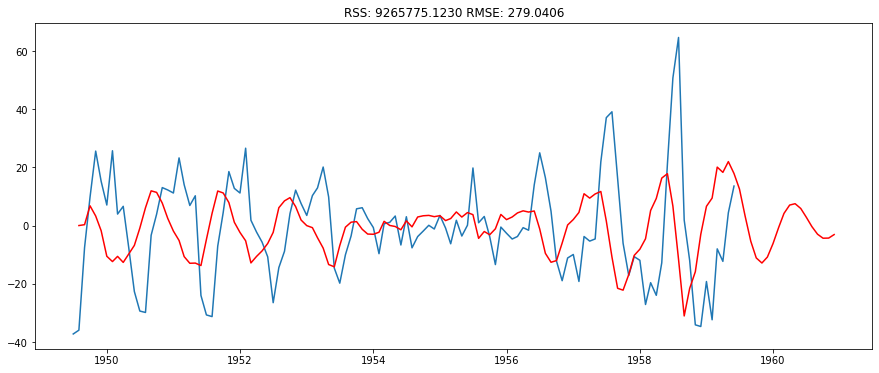

In [292]:
plt.plot(df_res)
plt.plot(pred, color= 'red')
RSS = sum((df_res-c).dropna()**2)
RMSE = np.sqrt(sum((df_res-c).dropna()**2)/len(c))
plt.title('RSS: %.4f'% RSS + ' RMSE: %.4f' % RMSE)